In [1]:

import vtk
import os
import numpy as np
import itertools
import math, random
import data_process_ml
random.seed = 42
import copy

import torch
from torch.utils.data import Dataset, DataLoader
from torch.utils.data import random_split
from torchvision import transforms, utils

import scipy.spatial.distance
# import plotly.graph_objects as go
# import plotly.express as px
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from pointnetfunct.PointNet_trainingfunct import run_model_get,run_model_3multi_head_dnn,run_model_2multi_head_dnn,load_model
from pointnetfunct.PointNet_struct import PointNet,PointNet_2Multimodal_withDNN,PointNet_3Multihead_withDNN




In [2]:
import open3d as o3d
def reduce_mesh(target_mesh, reference_mesh):
    # Find common vertices between the two meshes
    output_mesh = copy.deepcopy(target_mesh)
    target_vertices = set(tuple(vertex) for vertex in np.asarray(target_mesh.vertices))
    target_vertices_list = [tuple(vertex) for vertex in np.asarray(target_mesh.vertices)]
    index_dict = {item: index for index, item in enumerate(target_vertices_list)}
    reference_vertices = set(tuple(vertex) for vertex in np.asarray(reference_mesh.vertices))

    common_vertices = target_vertices.intersection(reference_vertices)
    #print(len(list(common_vertices)))
    list_mine = [index_dict[element_to_find] for element_to_find in list(common_vertices)]

    #print(list_mine)

    # Filter out vertices and triangles based on common vertices
    output_mesh.remove_vertices_by_index(list_mine)

    return output_mesh

def mesh_to_point_cloud(file_path,points = 10000):
    """
    Convert a mesh object to a point cloud object.
    """
    mesh = o3d.io.read_triangle_mesh(file_path)
    point_cloud = mesh.sample_points_uniformly(number_of_points=points) # Adjust number_of_points as needed
    return point_cloud

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


load the dataset

In [3]:
root = "..\..\msc_data\models-v1.0\models"
IA = "aneurysms\\remeshed\\area-001"
Vessel = "vessels\\remeshed\\area-001"
IA_root = os.path.join(root,IA)
Vessel_root = os.path.join(root,Vessel)
list1 = os.listdir(Vessel_root)
list2 = os.listdir(IA_root)

In [4]:
morpho_path = ".\AneuX\data-v1.0\data\morpho-per-cut.csv"
patient_path = ".\AneuX\data-v1.0\data\clinical.csv"
morpho_data_patient = data_process_ml.read_and_combine_data(morpho_path,patient_path)
merged_dataset = data_process_ml.encode_column(morpho_data_patient)
merged_dataset = data_process_ml.drop_columns(merged_dataset)
morpho_data_cut1,morpho_data_dome = data_process_ml.output_cut1anddome(merged_dataset)

d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(morpho_data_cut1.columns[3:23], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [5]:
import pandas as pd
from pointnetfunct.PointNet_dataset import Aneux_Dataset_load
df = pd.DataFrame()
# Aneux_Dataset = Aneuxmodel_Dataset(root = root,
#                                    df=morpho_data_patient[morpho_data_patient["cuttype"] == "dome"],
#                                    transform = transforms.ToTensor(),
#                                    mesh = "area-001",
#                                    cuttype = "dome",
#                                    crop = False)

Aneux_Dataset = Aneux_Dataset_load('./Aneux_Dataset_2000pt_ppd_600train.pt')
Aneux_Dataset.paraout = True
Aneux_Dataset_test = Aneux_Dataset_load('./Aneux_Dataset_2000pt_ppd_100test.pt')
Aneux_Dataset.cuttype = "cut1"
Aneux_Dataset_test.cuttype = "cut1"

d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:69: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(morpho_data_cut1.columns[3:23], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:70: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  morpho_data_cut1.drop(['source_x',"cuttype","dataset"], axis=1, inplace=True)
d:\Universityofleeds\MSC_PROG\Msc_project\code\data_process_ml.py:73: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/st

In [6]:
print(len(Aneux_Dataset.model_table),len(Aneux_Dataset.label))
print(Aneux_Dataset.points)

635 635
2000


In [7]:
from torch.utils.data import Subset

#1916614438200
seed = torch.seed()
print(seed)
torch.manual_seed(32381912834800)

train_size = int(len(Aneux_Dataset) * 0.85) # 80% training data
valid_size = len(Aneux_Dataset) - train_size
train_data, valid_data = random_split(Aneux_Dataset, [train_size, valid_size])

train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=50,
    shuffle=True,
    #num_workers=2, 
    pin_memory=True
)

valid_loader = torch.utils.data.DataLoader(
    valid_data,
    batch_size=50, # Forward pass only so batch size can be larger
    shuffle=False,
    #num_workers=2, 
    pin_memory=True
)

test_loader = torch.utils.data.DataLoader(
    Aneux_Dataset_test,
    batch_size=50, # Forward pass only so batch size can be larger
    shuffle=False,
    #num_workers=2, 
    pin_memory=True
)

48344627810300


Test vaildation

# PointNet model

In [8]:
import torch
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torch import optim
from pointnetfunct.PointNet_struct import Tnet,Transform,PointNet,PointNet_2Multihead,PointNet_3Multihead


Run model

In [9]:
import functions


pointnet = PointNet(classes=2)
run_model_get(train_loader_input = train_loader,
                        vaild_loader_input = valid_loader,
                        nepochs = 100, 
                        modelnet = pointnet,
                        results_path = "./result", 
                        filename = "/dome_ppd_2000pt_test.pt",
                        model_name="pointnet_ppd_2000pt.pth")
pointnet.to("cpu")

epoch: 0 training loss:  0.724 training accuracy:  58.6%  test loss:  0.698 test accuracy:  68.8%
epoch: 1 training loss:  0.699 training accuracy:  65.3%  test loss:  0.696 test accuracy:  66.7%
epoch: 2 training loss:  0.726 training accuracy:  63.8%  test loss:  0.710 test accuracy:  64.6%
epoch: 3 training loss:  0.676 training accuracy:  66.8%  test loss:  0.680 test accuracy:  68.8%
epoch: 4 training loss:  0.693 training accuracy:  67.0%  test loss:  0.704 test accuracy:  68.8%
epoch: 5 training loss:  0.684 training accuracy:  64.4%  test loss:  0.689 test accuracy:  68.8%
epoch: 6 training loss:  0.700 training accuracy:  66.2%  test loss:  0.687 test accuracy:  66.7%
epoch: 7 training loss:  0.704 training accuracy:  67.7%  test loss:  0.651 test accuracy:  70.8%
epoch: 8 training loss:  0.676 training accuracy:  68.5%  test loss:  0.662 test accuracy:  67.7%
epoch: 9 training loss:  0.687 training accuracy:  64.7%  test loss:  0.661 test accuracy:  70.8%
epoch: 10 training l

PointNet(
  (transform): Transform(
    (input_transform): Tnet(
      (conv1): Conv1d(3, 64, kernel_size=(1,), stride=(1,))
      (conv2): Conv1d(64, 128, kernel_size=(1,), stride=(1,))
      (conv3): Conv1d(128, 1024, kernel_size=(1,), stride=(1,))
      (fc1): Linear(in_features=1024, out_features=512, bias=True)
      (fc2): Linear(in_features=512, out_features=256, bias=True)
      (fc3): Linear(in_features=256, out_features=9, bias=True)
      (bn1): BatchNorm1d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn2): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn3): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn4): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (bn5): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (feature_transform): Tnet(
      (conv1): Conv1d(64, 64, kernel_size=(1,

In [10]:
def show_graph(path,device):
    data = torch.load(path, map_location=device) # by doing map_location=device, you can use trained model on GPU --> to test on CPU
    statsrec = data["stats"]
    fig, ax1 = plt.subplots()
    plt.plot(statsrec[0], 'r', label = 'training loss', )
    plt.plot(statsrec[2], 'g', label = 'test loss' )
    plt.legend(loc='lower right')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.title('Training and test loss, and test accuracy')
    ax2=ax1.twinx()
    ax2.plot(statsrec[1], 'm', label = 'training accuracy')
    ax2.plot(statsrec[3], 'b', label = 'test accuracy')
    ax2.set_ylabel('accuracy')
    plt.legend(loc='upper right')
    fig.savefig("roc.svg")
    plt.show()

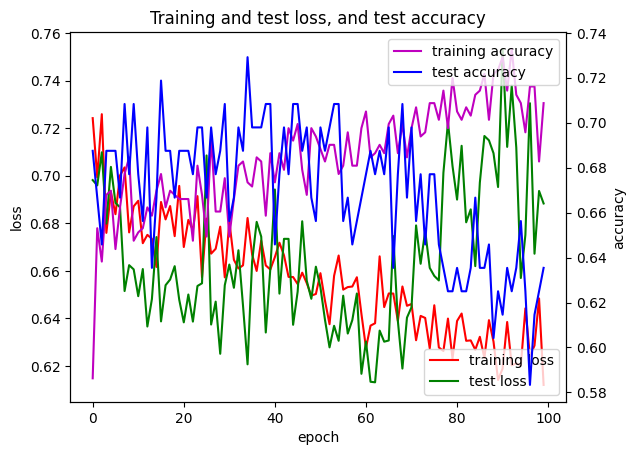

In [11]:
device = torch.device('cuda:0')
show_graph(path ="./result/dome_ppd_2000pt_test.pt",device = "cuda")

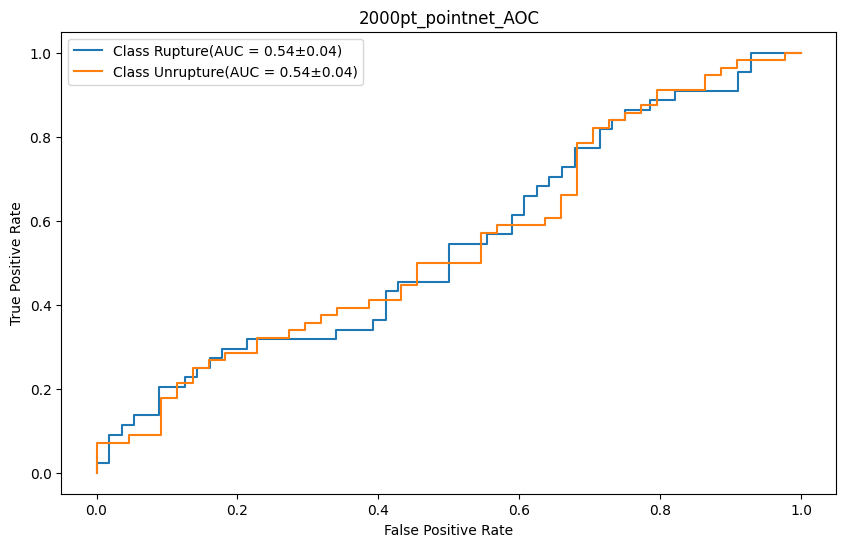

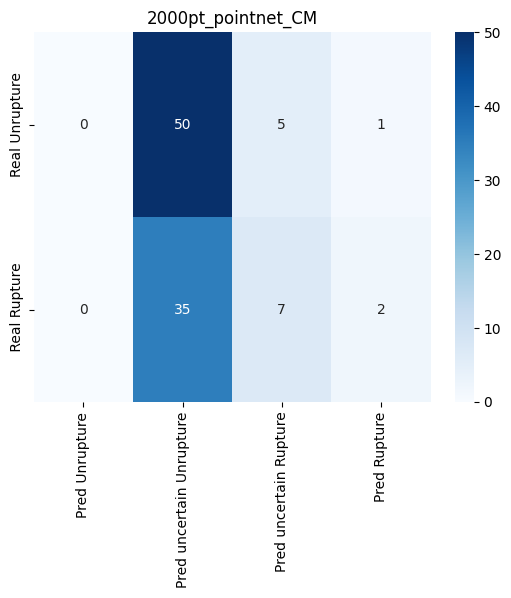

Accuracy: 0.59
F1 score: 0.30508474576271183
Rupture Recall: 0.20454545454545456
Rupture Precision: 0.6
UnRupture Recall: 0.8928571428571429
UnRupture Precision: 0.5882352941176471


In [12]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import functions as fun
pointnet_copy = PointNet(classes=2)
model_path = "./pointnet_ppd_2000pt.pth"
load_model(pointnet_copy,model_path)

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,_,_,labels in test_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="2000pt_pointnet_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="2000pt_pointnet_CM")
print_values (y_true, y_pred_result)


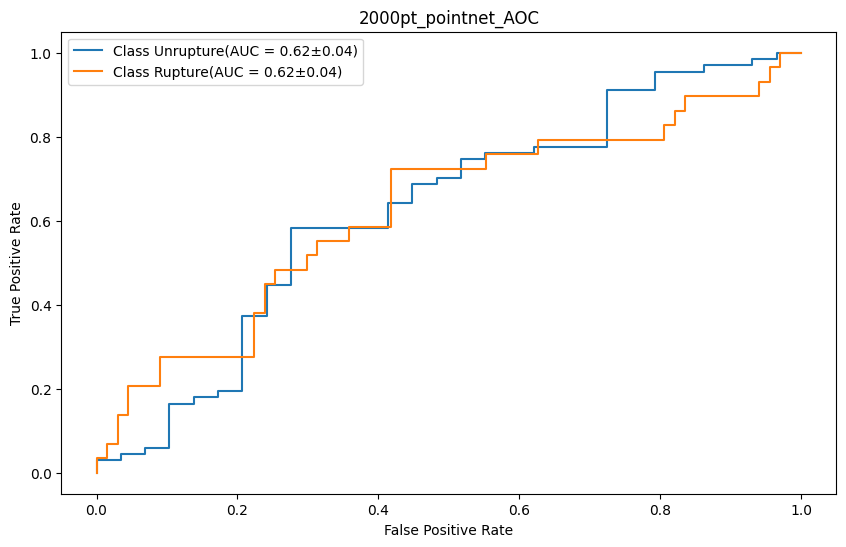

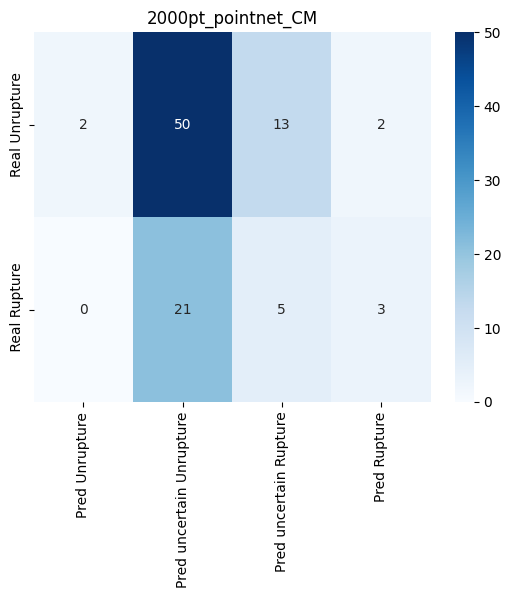

Accuracy: 0.625
F1 score: 0.3076923076923077
Rupture Recall: 0.27586206896551724
Rupture Precision: 0.34782608695652173
UnRupture Recall: 0.7761194029850746
UnRupture Precision: 0.7123287671232876


In [13]:
y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,_,_,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="2000pt_pointnet_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="2000pt_pointnet_CM")
print_values (y_true, y_pred_result)


Multi head

2branch multimodal

In [14]:
import functions
pointnet_2mh = PointNet_2Multimodal_withDNN(classes=2)
run_model_2multi_head_dnn(train_loader_input = train_loader,
                        vaild_loader_input = valid_loader,
                        nepochs = 100, 
                        modelnet = pointnet_2mh,
                        results_path = "./result", 
                        filename = "/2multibranch_ppd_2000pt_test.pt",
                        model_name="pointnet_2branch_modal_ppd_2000pt.pth")


epoch: 0 training loss:  0.727 training accuracy:  55.7%  test loss:  0.688 test accuracy:  67.7%
epoch: 1 training loss:  0.683 training accuracy:  62.5%  test loss:  0.693 test accuracy:  63.5%
epoch: 2 training loss:  0.678 training accuracy:  67.3%  test loss:  0.641 test accuracy:  67.7%
epoch: 3 training loss:  0.637 training accuracy:  67.5%  test loss:  0.617 test accuracy:  71.9%
epoch: 4 training loss:  0.621 training accuracy:  70.1%  test loss:  0.605 test accuracy:  68.8%
epoch: 5 training loss:  0.603 training accuracy:  72.2%  test loss:  0.575 test accuracy:  74.0%
epoch: 6 training loss:  0.615 training accuracy:  68.8%  test loss:  0.584 test accuracy:  77.1%
epoch: 7 training loss:  0.584 training accuracy:  72.7%  test loss:  0.565 test accuracy:  77.1%
epoch: 8 training loss:  0.607 training accuracy:  73.7%  test loss:  0.539 test accuracy:  77.1%
epoch: 9 training loss:  0.591 training accuracy:  73.1%  test loss:  0.566 test accuracy:  76.0%
epoch: 10 training l

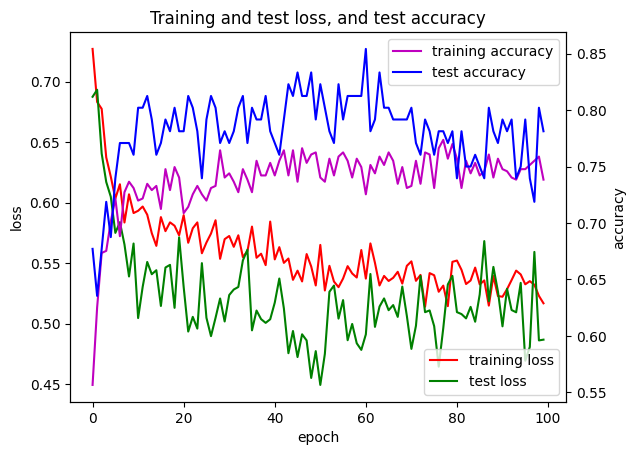

In [15]:
show_graph(path ="./result/2multibranch_ppd_2000pt_test.pt",device = "cuda")

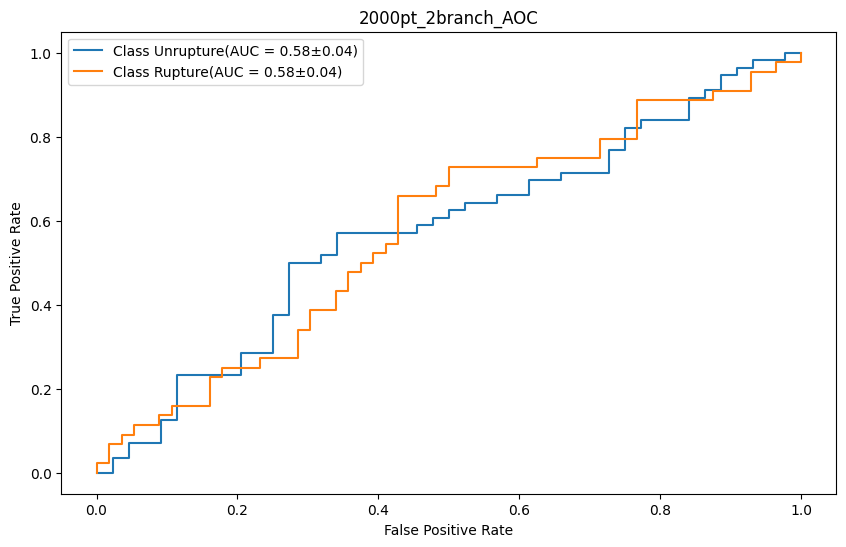

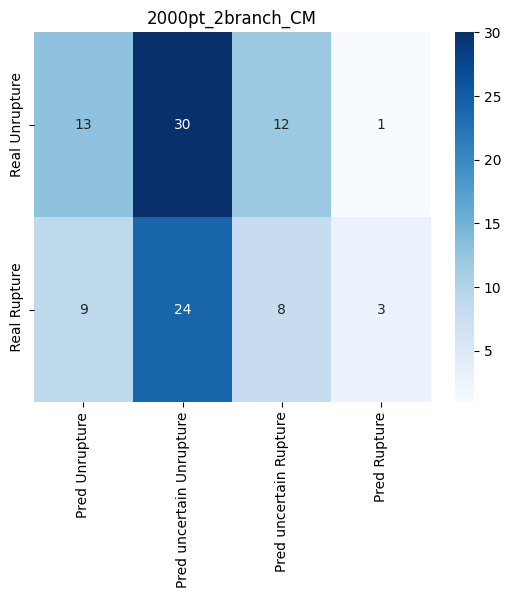

Accuracy: 0.54
F1 score: 0.3235294117647059
Rupture Recall: 0.25
Rupture Precision: 0.4583333333333333
UnRupture Recall: 0.7678571428571429
UnRupture Precision: 0.5657894736842105


In [16]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import functions as fun
pointnet_2mh.to("cpu")
pointnet_copy = PointNet_2Multimodal_withDNN(classes=2)
model_path = "./pointnet_2branch_modal_ppd_2000pt.pth"
load_model(pointnet_copy,model_path)

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in test_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)
        
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="2000pt_2branch_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="2000pt_2branch_CM")
print_values (y_true, y_pred_result)

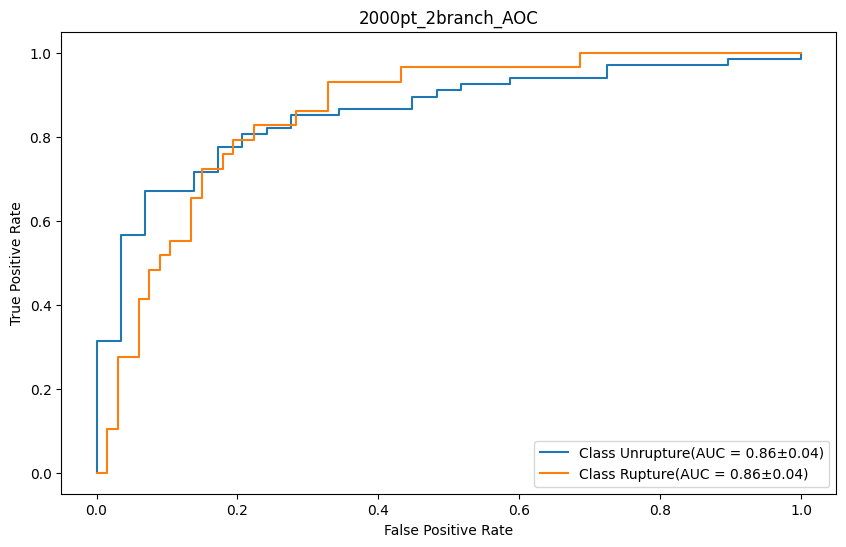

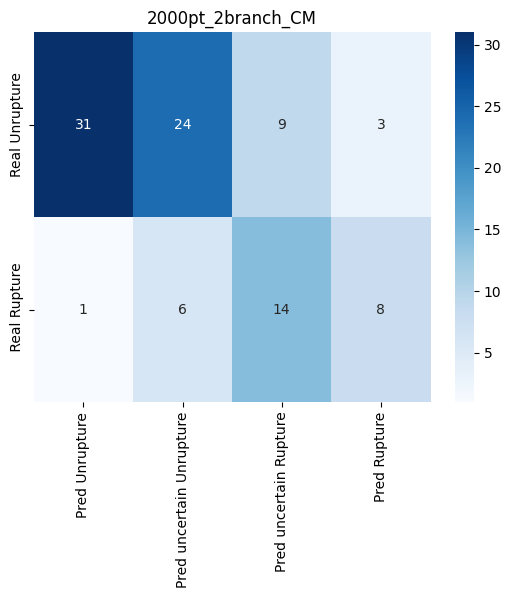

Accuracy: 0.8020833333333334
F1 score: 0.6984126984126984
Rupture Recall: 0.7586206896551724
Rupture Precision: 0.6470588235294118
UnRupture Recall: 0.8208955223880597
UnRupture Precision: 0.8870967741935484


In [17]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import functions as fun
pointnet_2mh.to("cpu")
pointnet_copy = PointNet_2Multimodal_withDNN(classes=2)
model_path = "./pointnet_2branch_modal_ppd_2000pt.pth"
load_model(pointnet_copy,model_path)

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)
        
        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="2000pt_2branch_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="2000pt_2branch_CM")
print_values (y_true, y_pred_result)

3multihead

In [9]:
import functions
pointnet_3mh = PointNet_3Multihead_withDNN(classes=2)
run_model_3multi_head_dnn(train_loader_input = train_loader,
                        vaild_loader_input = valid_loader,
                        nepochs = 100, 
                        modelnet = pointnet_3mh,
                        results_path = "./result", 
                        filename = "/3multibranch_ppd_2000pt_test.pt",
                        model_name="pointnet_3branch_modal_ppd_2000pt.pth")

epoch: 0 training loss:  0.716 training accuracy:  61.8%  test loss:  0.691 test accuracy:  67.7%
epoch: 1 training loss:  0.694 training accuracy:  67.9%  test loss:  0.688 test accuracy:  69.8%
epoch: 2 training loss:  0.661 training accuracy:  67.5%  test loss:  0.666 test accuracy:  67.7%
epoch: 3 training loss:  0.653 training accuracy:  72.0%  test loss:  0.630 test accuracy:  70.8%
epoch: 4 training loss:  0.631 training accuracy:  71.4%  test loss:  0.647 test accuracy:  68.8%
epoch: 5 training loss:  0.644 training accuracy:  70.7%  test loss:  0.609 test accuracy:  71.9%
epoch: 6 training loss:  0.623 training accuracy:  73.5%  test loss:  0.593 test accuracy:  74.0%
epoch: 7 training loss:  0.637 training accuracy:  71.1%  test loss:  0.636 test accuracy:  71.9%
epoch: 8 training loss:  0.625 training accuracy:  72.0%  test loss:  0.638 test accuracy:  75.0%
epoch: 9 training loss:  0.601 training accuracy:  72.5%  test loss:  0.607 test accuracy:  75.0%
epoch: 10 training l

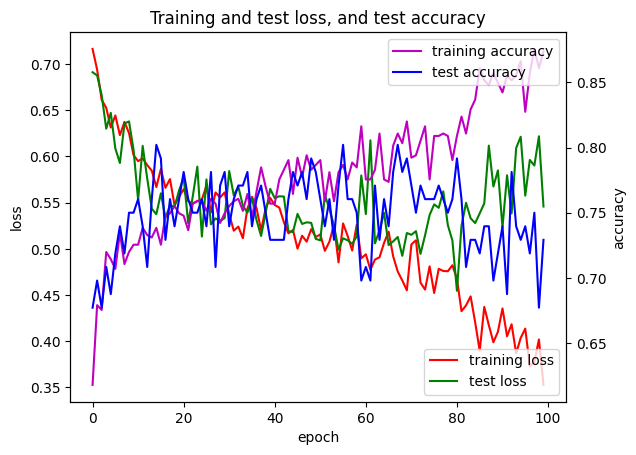

In [11]:
from pointnetfunct.evaluation import show_graph
device = torch.device('cuda:0')
show_graph(path ="./result/3multibranch_ppd_2000pt_test.pt",device = "cuda")

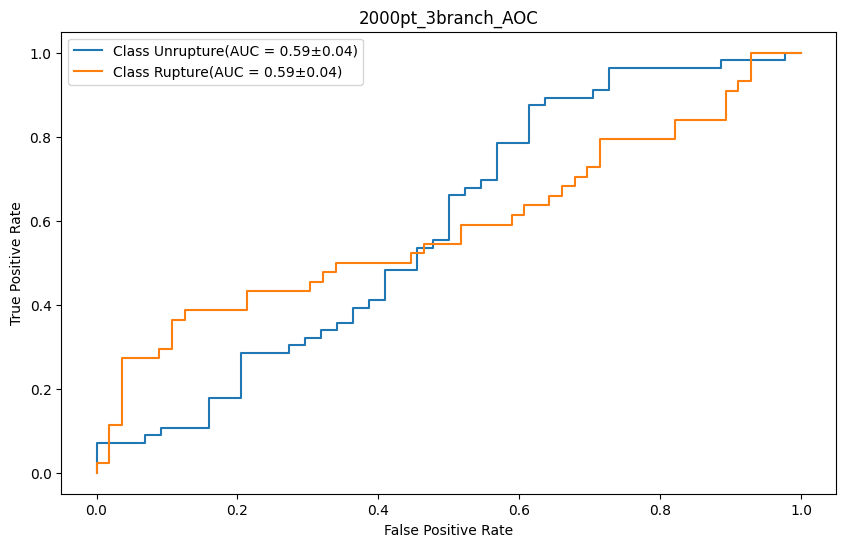

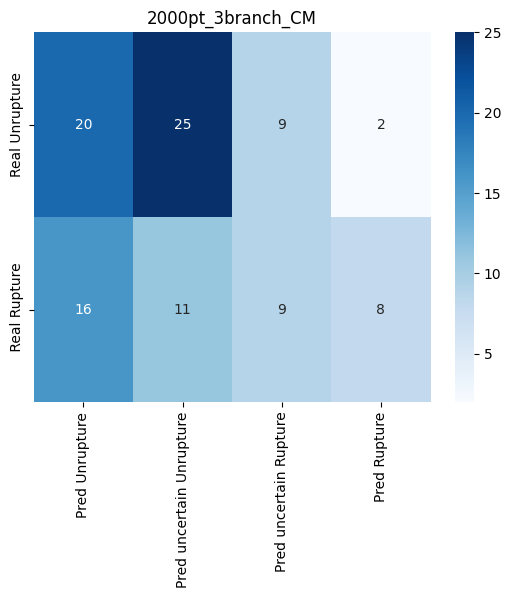

Accuracy: 0.62
F1 score: 0.4722222222222222
Rupture Recall: 0.38636363636363635
Rupture Precision: 0.6071428571428571
UnRupture Recall: 0.8035714285714286
UnRupture Precision: 0.625


In [12]:

from sklearn.metrics import confusion_matrix
import seaborn as sns
import functions as fun
pointnet_copy = PointNet_3Multihead_withDNN(classes=2)
model_path = "./pointnet_3branch_modal_ppd_2000pt.pth"
load_model(pointnet_copy,model_path)

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in test_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)

        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v2,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="2000pt_3branch_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="2000pt_3branch_CM")
print_values (y_true, y_pred_result)

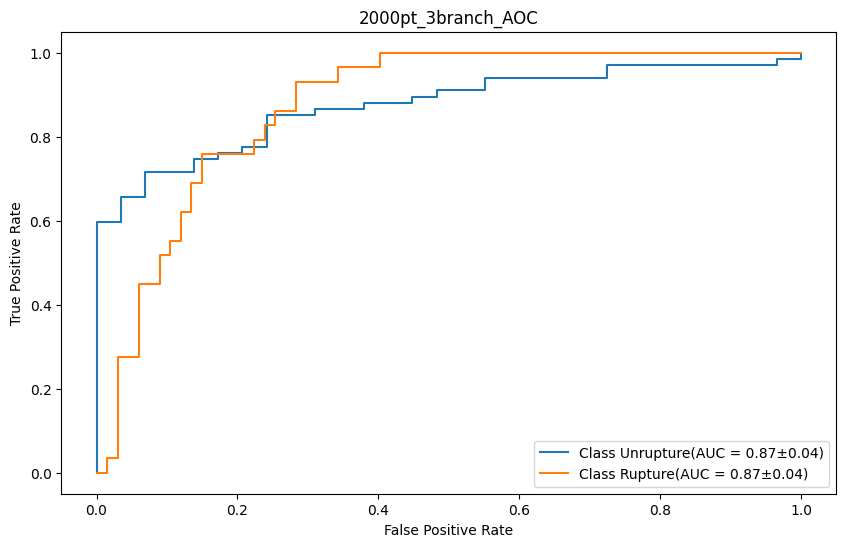

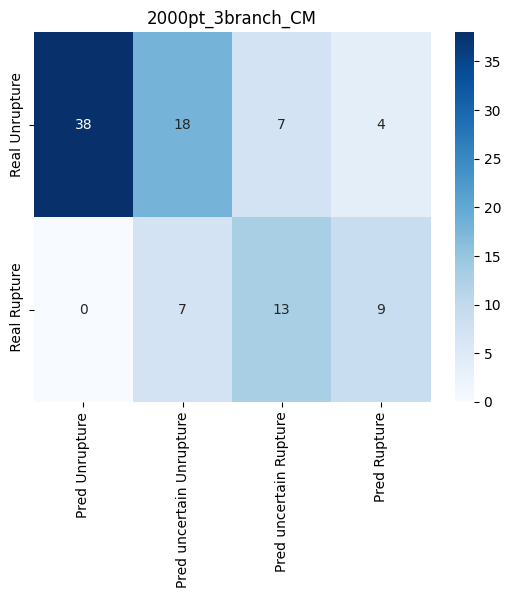

Accuracy: 0.8125
F1 score: 0.7096774193548386
Rupture Recall: 0.7586206896551724
Rupture Precision: 0.6666666666666666
UnRupture Recall: 0.835820895522388
UnRupture Precision: 0.8888888888888888


In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import functions as fun
pointnet_copy = PointNet_3Multihead_withDNN(classes=2)
model_path = "./pointnet_3branch_modal_ppd_2000pt.pth"
load_model(pointnet_copy,model_path)

y_true = []
y_pred = []
y_pred_result = []
y_probs = []
pointnet_copy = pointnet_copy.to("cpu")
with torch.no_grad():
    for inputs_v,inputs_v2,inputs_v3,labels in valid_loader:
        inputs_v = inputs_v.to(torch.float32)
        inputs_v = inputs_v.squeeze(1).permute(0, 2, 1)
        inputs_v2 = inputs_v2.to(torch.float32)
        inputs_v2 = inputs_v2.squeeze(1).permute(0, 2, 1)
        inputs_v3 = inputs_v3.to(torch.float32)

        labels = labels.to(torch.long)
        outputs = pointnet_copy.forward(inputs_v,inputs_v2,inputs_v3)
        
        #print(torch.exp(outputs))

        outputs_value = (torch.max(torch.exp(outputs), 1)[0]).data.cpu().numpy()
        outputs_result = (torch.max(torch.exp(outputs), 1)[1]).data.cpu().numpy()
        
        
        #print(outputs)
        y_pred.extend(outputs_value)
        y_pred_result.extend(outputs_result)
            
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) 
        y_probs.extend(outputs)

from pointnetfunct.evaluation import show_cm_dl,show_graph,print_values,draw_rocgraph

draw_rocgraph(y_pred_result,y_true, y_probs, name="2000pt_3branch_AOC", interval=0.04)
show_cm_dl(y_true, y_pred,y_pred_result,name="2000pt_3branch_CM")
print_values (y_true, y_pred_result)